## Implementation of a particle filter as part of an exercise of *Recursive Estimation*

### Introduction

We model a discrete-time temporal system as:

\begin{align}
    x(k) &= q_{k-1}(x(k-1), v(k-1) ), \\
    y(k) &= h_k(x(k), w(k)), 
\end{align}

where $x_k$ are latent states, $y_k$ are observations and $q$ and $h$ are (possibly non-linear) functions for states and observations at time $k \in \{0, 1, 2, \dots \}$.

We estimate the latent states using *Bayesian tracking* which usually consists of two steps:

* Prior update/state prediction: $f_p = f_{x(k) | z(k-1)} $
* Posterior update/filtering: $f_m = f_{x(k) | z(k) } $

A particle filter is an approximation of a Bayesian state estimator for general non-linear systems and noise distributions. We approximate the state distributions using a large number of samples called *particles*. The particles are propagated through the process model, weighted by their likelihood and then resampled given their weights.

First we load some `packages`:

In [1]:
from scipy.stats import norm, uniform, multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In this exercise we describe the system: 

\begin{align}
    x(k) &= \mathbf{A} x(k-1) + v(k-1), \\ 
    y(k) &= \mathbf{H} x(k) + w(k-1),
\end{align}

where $\mathbf{A} = \begin{pmatrix} 0.5 & 0 \\ 0 & 2 \end{pmatrix}$,  $\mathbf{H} = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$, $v \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) $ and $w \sim \mathcal{N}(\mathbf{0}, 2\mathbf{I}) $.

In [2]:
A = np.matrix([[.5, 0], [0, 2]])
print("Process model matrix:\n", A)
H = np.matrix([[1, 0], [0, 1]])
print("Observation model matrix:\n", H)

Process model matrix:
 [[ 0.5  0. ]
 [ 0.   2. ]]
Observation model matrix:
 [[1 0]
 [0 1]]


First we define a function that propagates the particles through the process model:

In [3]:
def state_update(particles, A, n):
    noise = np.matrix([norm.ppf(uniform.rvs(size=n), 0, 1), 
                       norm.ppf(uniform.rvs(size=n), 0, 1)])
    priors = np.matmul(A, particles.T) + noise
    return(priors.T)

The function `state_update` needs some particles for the first state update. Thus for $k=0$ we assume:

$$x_m(0) \sim \mathcal{N}(0, 1)$$ 

and sample $n = 10$ particles $\{ x_m^n(0) \}_{i=1}^n$. Throughout the exercise we assume we only have a random number generator for uniform random variables. Thus we sample from a normal distribution using the inverse CDF (the *percent point function*) and the uniform variates.

In [4]:
# particle count
n = 10

In [5]:
# use uniform samples to get normally distributed particles
particles = np.array([norm.ppf(uniform.rvs(size=n), 0, 1),
                      norm.ppf(uniform.rvs(size=n), 0, 1)]).T

We then use the particles for the process model to generate prior particles $\{ x_p^i(1) \}_{i=1}^n$.

In [6]:
prior = state_update(particles, A, n)

Then we weigh the prior particles $\{ x_p^i(1) \}_{i=1}^n$ by the measurement likelihood 

$$\beta_i = \frac{1}{Z} \ f_{y(k) | x(k)},$$

where $\frac{1}{Z}$ is a normalization constant such that $\sum_i \beta_i = 1$. Since we don't have the analytical form of the likelihood we use a *change of variables* using $f_{w} = \mathcal{N}(\mathbf{0}, 2\mathbf{I})$:

$$f_{y(k) | x(k)} = f_{w(k) | x(k)}( y(k) - x(k)).$$

We then evaluate the likelihood for every particle given an observation $y(k)$, in this case for $k=1$, and compute the weights.

For $k=1$, we observe the current's system state:

In [7]:
y = np.array([uniform.rvs(), uniform.rvs()])
y

array([ 0.00070647,  0.2735368 ])

Then we define a function to compute the weights $\beta_n$. Since we used a change of variables we also need to provide $w$'s mean and variance:

In [8]:
def compute_weights(particles, y, n, mean_w, var_w):
    betas = np.zeros(n)
    for i in range(particles.shape[0]):
        betas[i] = multivariate_normal.pdf(y - particles[i, :], mean_w, var_w)
    betas /= sum(betas)
    return(betas)

In [9]:
betas = compute_weights(particles, y, n, np.array([0, 0]), np.matrix([[2,0], [0,2]]))

Finally, using the likelihood weights, we resample particles to get some *posterior samples* $\{ x_m^i(1) \}_{i=1}^n$.

In [10]:
def resample_posterior_particles(betas, n, particles):
    runif = uniform.rvs(size=n, loc=0, scale=1)
    beta_cum = np.cumsum(betas)
    post_particles = np.zeros(shape=(n, 2))
    for i in range(particles.shape[0]):
        for j, e in enumerate(beta_cum):
            if runif[i] <= e:
                post_particles[i, :] = particles[j, :] 
                break
    return post_particles

In [11]:
particles = resample_posterior_particles(betas, n, particles)

By iteratively applying these functions we can estimate the system's current state for a specific $k$.

### Test

Lets test this with some iterations.

In [12]:
n = 100

states = np.zeros(shape=(10, 2))
observations = np.zeros(shape=(10, 2))

mean_v = np.array([0, 0])
var_v = np.matrix([[1, 0], [0, 1]])
mean_w = np.array([0, 0])
var_w = np.matrix([[2, 0], [0, 2]])

A = np.matrix([[1, 0.25], [0.25, 0.5]])

In [13]:
def plot(particles, states, observations, i):
    ax.scatter(x=particles[:, 0] , y=particles[:, 1], marker=".", color="b", alpha=0.1, label="Particles")    
    ax.scatter(x=observations[i, 0], y=observations[i, 1], marker="+", color="r", s=50, label="Observed state")
    ax.scatter(x=states[i, 0] , y=states[i, 1], marker="+", color="g", s=50, label="True state")

In [14]:
for i in range(1, 10):
    states[i, :] = np.matmul(A, states[i - 1, :]) + \
        abs(multivariate_normal.rvs(mean=mean_v, cov=var_v))
    observations[i, :] = states[i, :] + \
        abs(multivariate_normal.rvs(mean=mean_w, cov=var_w))
particles = np.array([norm.ppf(uniform.rvs(size=n), 0, 1), norm.ppf(uniform.rvs(size=n), 0, 1)]).T

In [15]:
states

array([[ 0.        ,  0.        ],
       [ 0.1263223 ,  1.33003241],
       [ 1.90920914,  1.28450294],
       [ 2.52817881,  1.56710678],
       [ 3.12471457,  1.67999561],
       [ 3.57245949,  2.26210475],
       [ 4.37322139,  2.45107255],
       [ 6.52679894,  3.09245788],
       [ 7.45978456,  3.71748457],
       [ 8.53437485,  4.53778683]])

In [16]:
observations

array([[  0.        ,   0.        ],
       [  1.02476695,   2.75285714],
       [  1.95856271,   1.40472226],
       [  3.30310749,   2.03824898],
       [  5.5905684 ,   3.63329313],
       [  5.10549532,   2.44988578],
       [  5.53419435,   3.50525141],
       [  8.7695414 ,   4.33006863],
       [  9.67965614,   4.35595199],
       [ 11.77538327,   5.78141851]])

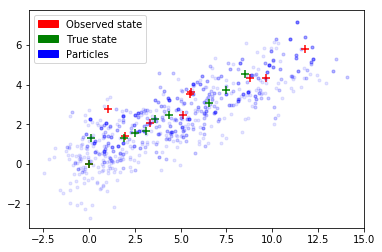

In [17]:
fig, ax = plt.subplots()
plot(particles, states, observations, 0)

for i in range(1, 10):    
    particles = state_update(particles, A, n)
    betas = compute_weights(particles, observations[i, :], n, mean_w, var_w)
    particles = resample_posterior_particles(betas, n, particles)
    plot(particles, states, observations, i)

red_patch = mpatches.Patch(color='red', label='Observed state')
green_patch = mpatches.Patch(color='green', label='True state')
blue_patch = mpatches.Patch(color='blue', label='Particles')
ax.legend(loc="upper left", handles=[red_patch, green_patch, blue_patch])

plt.savefig("_fig/particle_filter.png", dpi=720)
plt.show()